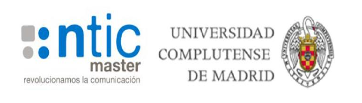

# NLP Deceitful Review Detection on e-Commerce and Social Media (2020)

This work is part of the final work to the <b>Master of Big Data and Business Analytics of the University Complutense of Madrid. 2019 - 2020.</b>

Authors: Marta Roig Atienza, Alejandra Lloret Calvo, Juan Pablo Guerrero Ortiz, Laura Débora Fernández Basquero, Ainhoa Rodrigo Bolea, Cristian Fernando Rodríguez Saldarriaga

# Deep Learning Model

Final Release

<b> Libraries </b> 

In [1]:
import numpy as np
import pandas as pd
import emoji
import en_core_web_sm
nlp = en_core_web_sm.load()
from textblob import TextBlob, Word
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns

## Function Definitions

### Cleaning Function

This function cleans symbols, invisible spaces and emojis off text. Also lemmatizes words if required with the desired method.

In [2]:
def clean_text(text,lemmatization): 
    
    """
    clean_text(text): general function in order to clean all the text-columns of the original dataset 
    
    INPUTS:
        
        text: each single sentence from every column and row of the data set
        lemmatization: select betweeen 
                            - Spacy lemmatization : "spacy"
                            - Textblob lemmatization: "textblob"
                            - Gensim lemmatization: "gensim"
                            - None: "none"
        
    OUTPUTS:
        
        df_clean : returns clean and lemmatize text-columns 
        
    """
    text =  text.lower() # convert to lowercase
    text =  text.replace("<br />", "") # HTML line break
    text =  text.replace('(&amp)', '') #  out logogram "&"
    text =  text.replace('(&gt)', '') # symbol of greater than (>)
    text =  text.replace('(&lt)', '') # symbol of lower than (>)
    text =  text.replace('(\xa0)', ' ') # out non-breaking space
    text =  text.replace('(\u200b)', ' ') # out non-breaking space
    
    #out emojis
    
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    
    
    # Different forms of lemmatization
    
    if lemmatization == "spacy":
        
        sent = []
        doc = nlp(text)
        for word in doc:
            sent.append(word.lemma_)
        text = " ".join(sent)
        
    elif lemmatization == "textblob":
        
        sent = TextBlob(text)
        tag_dict = {"J": 'a',
                    "N": 'n',
                    "V": 'v',
                    "R": 'r'}
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
        lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    
        text = " ".join(lemmatized_list)
        
    elif lemmatization == "gensim":
        
        text =  ' '.join([wd.decode('utf-8').split('/')[0] for wd in lemmatize(text)])
        
    elif lemmatization == "none":
        
        text = text
        
    return text

###     Create Model Function

This function creates a Deep Learning Sequential Model with Keras.

In [3]:
def create_model(vocab_size, embedding_dim, maxlen, rate1, num_filters1,
                  kernel_size1, padding, strides1, l2_1, rate2, num_filters2, kernel_size2, strides2,
                  l2_2, rate3, units, l2_3, rate4):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    model.add(layers.Dropout(rate=rate1))
    model.add(layers.Conv1D(filters=num_filters1, kernel_size=kernel_size1, padding=padding, activation="relu", strides=strides1, kernel_regularizer = regularizers.l2(l=l2_1)))
    model.add(layers.Dropout(rate=rate2))
    model.add(layers.Conv1D(filters=num_filters2, kernel_size=kernel_size2, padding=padding, activation="relu", strides=strides2, kernel_regularizer = regularizers.l2(l=l2_2)))
    model.add(layers.Dropout(rate=rate3))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(units=units, activation="relu", kernel_regularizer = regularizers.l2(l=l2_3)))
    model.add(layers.Dropout(rate=rate4))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Plot History Function

This function plots how the accuracy and loss evolve through the training process for both training and test values. This is useful to monitor overfitting and underfitting of the model.

In [4]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Create Embedding Matrix Function

This function creates an Embedding Matrix to use as weights in the Model Embedding Layer. This Embedding Matrix has as many rows as words in the corpus created from the words in our dataset (word_index) and as many columns as set by the parameter embedding_dim (later on we choose embedding_dim = 100 because the GloVe Embedding Output we are using has vectors of 100 components for each word present in it.

In [5]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding = "utf_8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

## Dataset Import

In [7]:
df_xtrain = pd.read_csv("Datasets/x_train_v2.csv",
                 names=['DOC_ID','RATING','VERIFIED_PURCHASE','PRODUCT_CATEGORY','PRODUCT_ID','PRODUCT_TITLE','REVIEW_TITLE'
                        ,'REVIEW_TEXT','ORIGINAL_REVIEW','ORIGINAL_REVIEW_TITLE','ORIGINAL_PRODUCT_TITLE','polarity'
                        ,'subjectivity','review_len','word_count','PUNCT','stopwords','CommonWords_count','Bigrams_count'
                        ,'Trigrams_count'],
                 sep=',',
                 header=0,
                 encoding="utf_8")
df_xtrain["fullReview"] = df_xtrain["ORIGINAL_PRODUCT_TITLE"] + " " + df_xtrain["ORIGINAL_REVIEW_TITLE"] + " " + df_xtrain["ORIGINAL_REVIEW"]
df_xtrain.fullReview=df_xtrain.fullReview.astype(str)

#Apply cleaning function to each column and row of the DataFrame    
df_xtrain['fullReview'] = df_xtrain['fullReview'].apply(lambda x: clean_text(x,"none"))

sentences_train = df_xtrain['fullReview'].values

df_xtrain

,DOC_ID,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,ORIGINAL_REVIEW,ORIGINAL_REVIEW_TITLE,...,polarity,subjectivity,review_len,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count,fullReview
0,7950,5,0,Outdoors,B00NQDF4KE,fly pedal universal clipless platform adapter,these pedal attach easily stay attached,these pedal attach easily stay attach like lot...,These pedals attach very easily and stay attac...,These pedals attach very easily and stay attached,...,0.261458,0.552083,167,25,3.3,30.6,2,0,0,fly pedals universal clipless platform adapter...
1,15517,5,1,Baby,B006JV4HC6,inglesina fast table chair liquirizia disconti...,work great,very sturdy attachment bar minimally obtrusive...,Very sturdy and the attachment bars are minima...,Works great!,...,0.161667,0.559167,192,29,2.7,37.0,4,1,0,"inglesina 2013 fast table chair, liquirizia (d..."
2,6686,5,1,Pet Products,B00SYWDA08,oternal electronic no bark control dog train c...,nicely do,skeptic first might also help unwanted visitor...,I was skeptic at first as this might also help...,nicely done !,...,0.583333,0.777778,115,18,2.8,44.1,1,0,0,oternal electronic no bark control dog trainin...
3,19782,5,0,PC,B0045VXKIE,verizon prepay usb broadband device,exaclty need,the provided laptop internet exactly expect th...,The USB760 3G provided my laptop with internet...,Exaclty what I needed,...,0.078889,0.447778,180,27,2.6,44.2,2,0,0,verizon usb760 3g prepaid usb broadband device...
4,2990,4,0,Musical Instruments,B003RQH5OI,drum ctklb coconut kalimba thumb piano,direction recommendation,add collection the negative comment tune direc...,I have added this to my collection The only ne...,no directions or recommendation ?,...,0.313333,0.386667,149,24,0.9,52.9,3,0,0,x8 drums x8-ct-klb coconut kalimba thumb piano...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15745,7551,5,1,Camera,B00L73WZNE,waterproof camera float by floatogear lanyard ...,best waterproof camera float,love put waterproof camera waterproof camera f...,I love it because I can put my waterproof came...,BEST Waterproof Camera Float,...,0.486667,0.526667,174,27,2.8,42.6,5,0,0,waterproof camera float by floatogear - lanyar...
15746,4379,5,1,Home,B00NQI8QTU,icooker soap dispenser automatic kitchen hand ...,best product,buy sensor pump kitchen sink buy bathroom it b...,"I bought the sensor Pump for my kitchen sink, ...",Best product,...,0.455556,0.358974,135,23,2.3,37.5,3,0,0,icooker soap dispenser - automatic kitchen han...
15747,17135,5,1,Kitchen,B0075WF6V4,crockpot b manual slow cooker quart,nice size crock pot for two plus leftover,how go wrong crock pot we need small size croc...,How can you go wrong with a Crock Pot? We nee...,NICE SIZE CROCK POT FOR TWO PLUS LEFTOVERS,...,-0.047619,0.509524,170,30,2.4,39.2,5,1,0,"crock-pot scr300-b manual slow cooker, 3 quart..."
15748,17470,3,1,Electronics,B009W9V2N4,bluerigger high speed micro hdmi hdmi cable et...,bluerigger high speed micro cable,subject bluerigger cable fit kindle hdx fire b...,Subject BlueRigger cable does not fit the Kind...,BlueRigger High Speed Micro Cable,...,0.116667,0.366667,71,11,0.0,54.2,1,0,0,bluerigger high speed micro hdmi to hdmi cable...


In [8]:
df_xtest = pd.read_csv("Datasets/x_test_v2.csv",
                 names=['DOC_ID','RATING','VERIFIED_PURCHASE','PRODUCT_CATEGORY','PRODUCT_ID','PRODUCT_TITLE','REVIEW_TITLE'
                        ,'REVIEW_TEXT','ORIGINAL_REVIEW','ORIGINAL_REVIEW_TITLE','ORIGINAL_PRODUCT_TITLE','polarity'
                        ,'subjectivity','review_len','word_count','PUNCT','stopwords','CommonWords_count','Bigrams_count'
                        ,'Trigrams_count'],
                 sep=',',
                 header=0,
                 encoding="utf_8")
df_xtest["fullReview"] = df_xtest["ORIGINAL_PRODUCT_TITLE"] + " " + df_xtest["ORIGINAL_REVIEW_TITLE"] + " " + df_xtest["ORIGINAL_REVIEW"]
df_xtest.fullReview=df_xtest.fullReview.astype(str)

#Apply cleaning function to each column and row of the DataFrame    
df_xtest['fullReview'] = df_xtest['fullReview'].apply(lambda x: clean_text(x,"none"))

sentences_test = df_xtest['fullReview'].values

df_xtest

,DOC_ID,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,ORIGINAL_REVIEW,ORIGINAL_REVIEW_TITLE,...,polarity,subjectivity,review_len,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count,fullReview
0,17947,5,1,Grocery,B0001IOSDQ,noh chinese barbecue char siu ounce packet pack,great sparerib maranade,would recommend product anyone love chinese sp...,I would recommend this product to anyone who l...,Great sparerib maranade.,...,0.408333,0.650000,94,14,2.9,33.3,4,1,0,"noh chinese barbecue (char siu), 2.5-ounce pac..."
1,1448,4,0,Baby,B00AX52Q0E,safety guide sport convertible car seat lydia,nice carseat,very comfortable lot pad plenty room also cars...,Very comfortable. Lots of padding. Plenty of r...,nice carseat,...,0.525556,0.680556,127,20,4.6,35.5,2,0,0,safety 1st - guide 65 sport convertible car se...
2,20580,1,1,Wireless,B00FK0ECYA,wallet trackr bluetooth device retail packagin...,wait next generation,the finder sound hardly hear love phone system...,The &#34;finder&#34; sound can hardly be heard...,Wait for next generation,...,0.401667,0.548333,98,17,9.6,37.9,4,0,0,wallet trackr - bluetooth 4.0 device - retail ...
3,10699,3,0,Camera,B00AR95FPO,sony hdrb high definition handycam camcorder i...,teeny tiny mess,the sony hdr miniscule light weight video came...,"The Sony HDR-PJ380 is a miniscule, light weigh...",Teeny Tiny Mess,...,0.093363,0.474906,5664,888,4.4,43.5,95,2,0,sony hdr-pj380/b high definition handycam camc...
4,16443,5,1,Beauty,B001ET77GQ,lobe wonder earring support patch count box pack,save ear now,my lobe stretch outyet but like prevent happen...,"My lobes are not stretched out-yet. But, I lik...",save you ears now!,...,-0.450000,0.583333,114,21,4.5,50.0,4,1,0,"lobe wonder earring support patches, 60-count ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,13583,3,1,Home,B008KMBFA4,kassatex apawbw parisian waste basket,nice design lightweight fragile material,very nice look waste basket lightweight fragil...,"Very nice looking waste basket, but very light...","Nice Design, Lightweight and Fragile Material",...,0.117738,0.530952,153,24,2.1,40.0,1,0,0,kassatex apa-wb-w parisian waste basket nice d...
5246,18964,5,1,Camera,B004TJ6JH6,lead cn dimmable ultra high power panel digita...,also like take camera,lightweight dimmable need also like take camer...,Lightweight and dimmable - just what I needed....,I also like that I can take it off of the came...,...,0.133333,0.600000,86,14,2.4,53.1,1,0,0,160 led cn-160 dimmable ultra high power panel...
5247,11210,5,0,Tools,B006MHSNWM,bioguard silk smart stick oz,so easy use toss skimmer,eight ounce silk stick bioguardso easy use tos...,Eight ounce. Silk Sticks from Bioguard.<br />S...,So easy to use just toss in the skimmer or in ...,...,0.201042,0.587351,285,47,3.0,41.5,4,1,0,bioguard silk smart stick - 8 oz so easy to us...
5248,20808,5,0,Jewelry,B00J28CM20,bling jewelry silver gold plat daisy flower da...,totally happy,love it it exactly want though meant charm bra...,I love it. It is exactly what I wanted. Thou...,Totally happy with it,...,0.406250,0.680714,208,35,3.8,52.0,9,2,1,bling jewelry 925 silver gold plated daisy flo...


In [9]:
df_ytrain = pd.read_csv("Datasets/y_train_v2.csv",
                 names=['LABEL'],
                 sep=',',
                 header=0,
                 encoding="utf_8")
df_ytrain.LABEL.replace({"fake": 0, "true": 1}, inplace = True)

y_train = df_ytrain['LABEL'].values

In [10]:
df_ytest = pd.read_csv("Datasets/y_test_v2.csv",
                 names=['LABEL'],
                 sep=',',
                 header=0,
                 encoding="utf_8")
df_ytest.LABEL.replace({"fake": 0, "true": 1}, inplace = True)

y_test = df_ytest['LABEL'].values

## Tokenization

The Tokenizer utility class can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary (tokenizer.word_index) that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. The parameter num_words sets the size of the vocabulary where the most common num_words words will be kept.

##### Arguments
num_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept. Default: num_words=None

filters: a string where each element is a character that will be filtered from the texts. The default is all punctuation, plus tabs and line breaks, minus the ' character. Default: filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n'

lower: boolean. Whether to convert the texts to lowercase. Default: lower=True

split: str. Separator for word splitting. Default: split=" "

char_level: if True, every character will be treated as a token. Default: char_level=False

oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls By default, all punctuation is removed, turning the texts into space-separated sequences of words (words maybe include the ' character). These sequences are then split into lists of tokens. They will then be indexed or vectorized. Default: oov_token=None

0 is a reserved index that won't be assigned to any word.

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
number_of_words = str(len(vectorizer.vocabulary_))
print("Number of unique words in the corpus: " + number_of_words)

Number of unique words in the corpus: 45165


In [12]:
tokenizer = Tokenizer(num_words=len(vectorizer.vocabulary_)) # OJO AL LEMATIZAR

# Updates internal vocabulary based on a list of texts.Required before using texts_to_sequences.
tokenizer.fit_on_texts(sentences_train) 

# Transforms each text in texts to a sequence of integers.
# Only top num_words-1 most frequent words will be taken into account. 
# Only words known by the tokenizer will be taken into account.
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
vocab_size
# print(tokenizer.word_index)

46942

## Padding

In [13]:
# Pad sequences with zeros
maxlen = 1500
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Embedding Matrix by Transfer Learning from GloVe: Global Vectors for Word Representation

Creation of a specific Embedding Matrix for our corpus using the vectors resulting from GloVe. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
https://nlp.stanford.edu/projects/glove/

In [14]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix("embedding\glove.6B.300d.txt",
                                           tokenizer.word_index,
                                           embedding_dim)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("Proportion of corpus's words included in the embedding: " + str(nonzero_elements / vocab_size))

Proportion of corpus's words included in the embedding: 0.6620723445954583


## Parameter Grid Definition

In [15]:
param_grid = dict(vocab_size = [vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen = [maxlen],
                  rate1 = [0.25, 0.5],
                  num_filters1=[64, 128, 256],
                  kernel_size1=[3, 5, 7, 9],
                  padding = ["valid", "causal", "same"],
                  strides1 = [2, 3, 4],
                  l2_1 = [0.0001, 0.001],
                  rate2 = [0.25, 0.5],
                  num_filters2=[64, 128, 256],
                  kernel_size2=[3, 5, 7, 9],
                  strides2 = [2, 3, 4],
                  l2_2 = [0.0001, 0.001],
                  rate3 = [0.25, 0.5],
                  units=[128, 256, 512],
                  l2_3 = [0.0001, 0.001],
                  rate4 = [0.25, 0.5])

## Cross Validation for Model Tunning

In [16]:
model = KerasClassifier(build_fn=create_model,
                        epochs=7, batch_size=100,
                        verbose=True)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=25, random_state=1000)
grid_result = grid.fit(X_train, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Epoch 1/7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


119/119 [==============================] - 52s 436ms/step - loss: 0.9025 - accuracy: 0.5388
Epoch 2/7
119/119 [==============================] - 53s 443ms/step - loss: 0.8093 - accuracy: 0.5862
Epoch 3/7
119/119 [==============================] - 53s 442ms/step - loss: 0.7427 - accuracy: 0.6224
Epoch 4/7
119/119 [==============================] - 53s 447ms/step - loss: 0.6809 - accuracy: 0.6647
Epoch 5/7
119/119 [==============================] - 54s 451ms/step - loss: 0.6196 - accuracy: 0.7121
Epoch 6/7
119/119 [==============================] - 53s 444ms/step - loss: 0.5407 - accuracy: 0.7651
Epoch 7/7
40/40 [==============================] - 3s 75ms/step - loss: 0.7129 - accuracy: 0.6348
Epoch 1/7
119/119 [==============================] - 53s 445ms/step - loss: 0.9136 - accuracy: 0.5359
Epoch 2/7
119/119 [==============================] - 53s 444ms/step - loss: 0.8158 - accuracy: 0.5897
Epoch 3/7
119/119 [==============================] - 53s 446ms/step - loss: 0.7475 - accuracy: 0

119/119 [==============================] - 113s 947ms/step - loss: 0.7360 - accuracy: 0.6589
Epoch 4/7
119/119 [==============================] - 112s 944ms/step - loss: 0.6539 - accuracy: 0.7171
Epoch 5/7
119/119 [==============================] - 112s 945ms/step - loss: 0.5867 - accuracy: 0.7700
Epoch 6/7
119/119 [==============================] - 112s 945ms/step - loss: 0.5032 - accuracy: 0.8292
Epoch 7/7
40/40 [==============================] - 7s 174ms/step - loss: 0.8226 - accuracy: 0.6275
Epoch 1/7
119/119 [==============================] - 111s 934ms/step - loss: 1.0271 - accuracy: 0.5436
Epoch 2/7
119/119 [==============================] - 111s 931ms/step - loss: 0.8310 - accuracy: 0.6039
Epoch 3/7
119/119 [==============================] - 111s 930ms/step - loss: 0.7351 - accuracy: 0.6513
Epoch 4/7
119/119 [==============================] - 111s 935ms/step - loss: 0.6552 - accuracy: 0.7139
Epoch 5/7
119/119 [==============================] - ETA: 0s - loss: 0.5823 - accuracy:

119/119 [==============================] - 44s 373ms/step - loss: 0.7053 - accuracy: 0.5881
Epoch 5/7
119/119 [==============================] - 44s 369ms/step - loss: 0.6950 - accuracy: 0.6031
Epoch 6/7
119/119 [==============================] - 43s 365ms/step - loss: 0.6765 - accuracy: 0.6227
Epoch 7/7
40/40 [==============================] - 2s 54ms/step - loss: 0.6937 - accuracy: 0.6012
Epoch 1/7
119/119 [==============================] - 44s 371ms/step - loss: 0.7419 - accuracy: 0.5235
Epoch 2/7
119/119 [==============================] - 45s 376ms/step - loss: 0.7257 - accuracy: 0.5370
Epoch 3/7
119/119 [==============================] - 45s 376ms/step - loss: 0.7131 - accuracy: 0.5714
Epoch 4/7
119/119 [==============================] - 43s 364ms/step - loss: 0.7016 - accuracy: 0.5876
Epoch 5/7
119/119 [==============================] - 44s 374ms/step - loss: 0.6867 - accuracy: 0.6159
Epoch 6/7
119/119 [==============================] - 44s 374ms/step - loss: 0.6734 - accuracy: 0

119/119 [==============================] - 44s 370ms/step - loss: 0.7366 - accuracy: 0.6140
Epoch 7/7
40/40 [==============================] - 2s 57ms/step - loss: 0.7300 - accuracy: 0.6002
Epoch 1/7
119/119 [==============================] - 43s 358ms/step - loss: 0.8909 - accuracy: 0.5231
Epoch 2/7
119/119 [==============================] - 43s 364ms/step - loss: 0.8423 - accuracy: 0.5332
Epoch 3/7
119/119 [==============================] - 44s 372ms/step - loss: 0.8062 - accuracy: 0.5552
Epoch 4/7
119/119 [==============================] - 43s 361ms/step - loss: 0.7768 - accuracy: 0.5780
Epoch 5/7
119/119 [==============================] - 43s 361ms/step - loss: 0.7541 - accuracy: 0.5933
Epoch 6/7
119/119 [==============================] - 45s 381ms/step - loss: 0.7314 - accuracy: 0.6129
Epoch 7/7
40/40 [==============================] - 2s 49ms/step - loss: 0.7339 - accuracy: 0.5875
Epoch 1/7
119/119 [==============================] - 101s 849ms/step - loss: 0.9023 - accuracy: 0.51

119/119 [==============================] - 84s 707ms/step - loss: 0.8610 - accuracy: 0.5223
Epoch 2/7
119/119 [==============================] - 85s 713ms/step - loss: 0.7854 - accuracy: 0.5639
Epoch 3/7
119/119 [==============================] - 84s 709ms/step - loss: 0.7414 - accuracy: 0.5952
Epoch 4/7
119/119 [==============================] - 85s 712ms/step - loss: 0.7044 - accuracy: 0.6318
Epoch 5/7
119/119 [==============================] - 85s 711ms/step - loss: 0.6663 - accuracy: 0.6598
Epoch 6/7
119/119 [==============================] - 84s 710ms/step - loss: 0.6364 - accuracy: 0.6898
Epoch 7/7
40/40 [==============================] - 6s 138ms/step - loss: 0.7063 - accuracy: 0.6043
Epoch 1/7
119/119 [==============================] - 67s 561ms/step - loss: 1.0575 - accuracy: 0.5420
Epoch 2/7
119/119 [==============================] - 67s 567ms/step - loss: 0.9004 - accuracy: 0.5867
Epoch 3/7
119/119 [==============================] - 68s 570ms/step - loss: 0.8192 - accuracy: 

119/119 [==============================] - 69s 584ms/step - loss: 0.7396 - accuracy: 0.6250
Epoch 4/7
119/119 [==============================] - 70s 585ms/step - loss: 0.6841 - accuracy: 0.6675
Epoch 5/7
119/119 [==============================] - 69s 581ms/step - loss: 0.6313 - accuracy: 0.7135
Epoch 6/7
119/119 [==============================] - 69s 583ms/step - loss: 0.5727 - accuracy: 0.7627
Epoch 7/7
40/40 [==============================] - 3s 73ms/step - loss: 0.7931 - accuracy: 0.6066
Epoch 1/7
119/119 [==============================] - 91s 766ms/step - loss: 0.8727 - accuracy: 0.5305
Epoch 2/7
119/119 [==============================] - 91s 764ms/step - loss: 0.8081 - accuracy: 0.5665
Epoch 3/7
119/119 [==============================] - 90s 756ms/step - loss: 0.7640 - accuracy: 0.6012
Epoch 4/7
119/119 [==============================] - 90s 757ms/step - loss: 0.7241 - accuracy: 0.6290
Epoch 5/7
119/119 [==============================] - 90s 759ms/step - loss: 0.6804 - accuracy: 0

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 830.8min finished


Epoch 1/7
158/158 [==============================] - 93s 590ms/step - loss: 1.0229 - accuracy: 0.5511
Epoch 2/7
158/158 [==============================] - 94s 592ms/step - loss: 0.8498 - accuracy: 0.5974
Epoch 3/7
158/158 [==============================] - 93s 591ms/step - loss: 0.7670 - accuracy: 0.6267
Epoch 4/7
158/158 [==============================] - 94s 594ms/step - loss: 0.7114 - accuracy: 0.6589
Epoch 5/7
158/158 [==============================] - 94s 595ms/step - loss: 0.6792 - accuracy: 0.6819
Epoch 6/7
158/158 [==============================] - 94s 596ms/step - loss: 0.6418 - accuracy: 0.7137
Epoch 7/7
158/158 [==============================] - 94s 595ms/step - loss: 0.6109 - accuracy: 0.7388


## Get Best Parameters for the model

In [19]:
grid_result.best_params_

{'vocab_size': 30892,
 'units': 512,
 'strides2': 4,
 'strides1': 4,
 'rate4': 0.25,
 'rate3': 0.25,
 'rate2': 0.5,
 'rate1': 0.5,
 'padding': 'same',
 'num_filters2': 256,
 'num_filters1': 256,
 'maxlen': 1500,
 'l2_3': 0.0001,
 'l2_2': 0.001,
 'l2_1': 0.001,
 'kernel_size2': 5,
 'kernel_size1': 5,
 'embedding_dim': 100}

## Run Best Model

Epoch 1/7
158/158 [==============================] - 193s 1s/step - loss: 1.1181 - accuracy: 0.5360 - val_loss: 0.9487 - val_accuracy: 0.6042
Epoch 2/7
158/158 [==============================] - 202s 1s/step - loss: 0.8709 - accuracy: 0.6208 - val_loss: 0.8288 - val_accuracy: 0.6074
Epoch 3/7
158/158 [==============================] - 202s 1s/step - loss: 0.7631 - accuracy: 0.6970 - val_loss: 0.8050 - val_accuracy: 0.6383
Epoch 4/7
158/158 [==============================] - 203s 1s/step - loss: 0.6997 - accuracy: 0.7535 - val_loss: 0.8103 - val_accuracy: 0.6627
Epoch 5/7
158/158 [==============================] - 202s 1s/step - loss: 0.6239 - accuracy: 0.8109 - val_loss: 0.8223 - val_accuracy: 0.6737
Epoch 6/7
158/158 [==============================] - 202s 1s/step - loss: 0.5567 - accuracy: 0.8579 - val_loss: 0.8784 - val_accuracy: 0.6670
Epoch 7/7
493/493 [==============================] - 33s 68ms/step - loss: 0.3959 - accuracy: 0.9749
Training Accuracy: 0.9749
165/165 [============

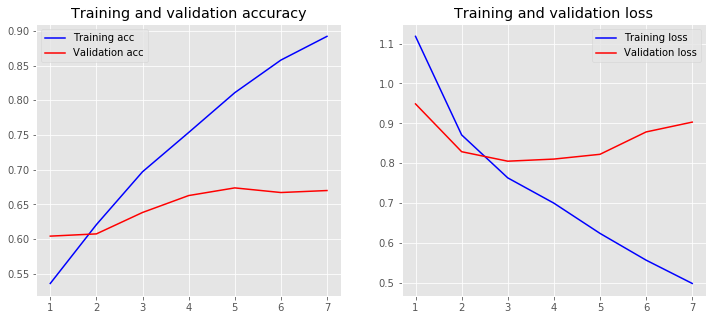

In [14]:
model = create_model(vocab_size = vocab_size, embedding_dim = embedding_dim, maxlen = maxlen, rate1 = 0.5, 
                     num_filters1 = 256, kernel_size1 = 5, padding = 'same', strides1 = 4, l2_1 = 0.001, rate2 = 0.5, 
                     num_filters2 = 256, kernel_size2 = 5, strides2 = 4, l2_2 = 0.001, rate3 = 0.25, units = 512,
                     l2_3 = 0.0001, rate4 = 0.25)

history = model.fit(X_train, y_train,
                    epochs = 7,
                    verbose = True,
                    validation_data = (X_test, y_test),
                    batch_size = 100)
loss, accuracy = model.evaluate(X_train, y_train, verbose = True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose = True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Save Best Model

In [15]:
# Save to file in the current working directory
model.save('deep_learning_model-6699.h5')
dl_model = keras.models.load_model('deep_learning_model-6699.h5')
dl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 300)         14082600  
_________________________________________________________________
dropout (Dropout)            (None, 1500, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 375, 256)          384256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 375, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 256)           327936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 94, 256)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0

## Model Performance Metrics

In [16]:
y_pred_test = (dl_model.predict(X_test) > 0.5).astype("int32")
y_pred_train = (dl_model.predict(X_train) > 0.5).astype("int32")

np.savetxt('Datasets/prediction_test.txt', y_pred_test, fmt='%i')
np.savetxt('Datasets/prediction_train.txt', y_pred_train, fmt='%i')

y_pred_test_prob = dl_model.predict(X_test)
y_pred_train_prob = dl_model.predict(X_train)

np.savetxt('Datasets/prediction_test_prob.txt', y_pred_test_prob, fmt='%10.5f')
np.savetxt('Datasets/prediction_train_prob.txt', y_pred_train_prob, fmt='%10.5f')

### Interpretation classification_report:

In [17]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2625
           1       0.67      0.67      0.67      2625

    accuracy                           0.67      5250
   macro avg       0.67      0.67      0.67      5250
weighted avg       0.67      0.67      0.67      5250



### Confusion Matrix

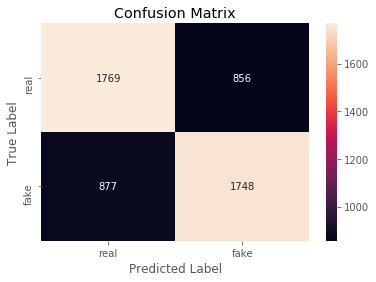

In [18]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
class_label = ["real", "fake"]
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show() 

### ROC Curve

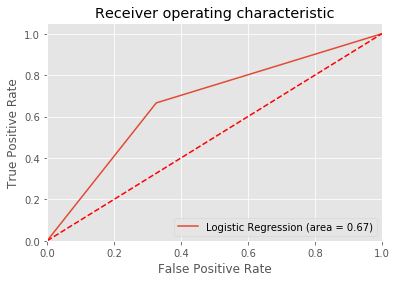

In [19]:
logit_roc_auc = roc_auc_score(y_test.ravel(), y_pred_test)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred_test)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Get Prediction Array as feature for Machine Learning Models

In [20]:
df_xtrain['DL_CLASSIFICATION_bin'] = pd.DataFrame(y_pred_train)
df_xtrain['DL_CLASSIFICATION_con'] = pd.DataFrame(y_pred_train_prob)

In [21]:
df_xtest['DL_CLASSIFICATION_bin'] = pd.DataFrame(y_pred_test)
df_xtest['DL_CLASSIFICATION_con'] = pd.DataFrame(y_pred_test_prob)

In [22]:
df_xtrain.to_csv(r'Datasets\x_train_DL-6699.csv', index = False, header=True)
df_xtest.to_csv(r'Datasets\x_test_DL-6699.csv', index = False, header=True)

__Project idea:__
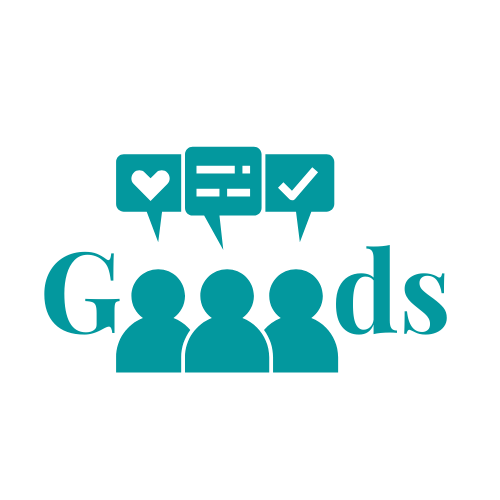



Developed by the following authors: 

 _Ainhoa Rodrigo Bolea (ainhoa2612@gmail.com)_
 
 _Alejandra Lloret Calvo (alejandralloretc@gmail.com)_
 
 _Cristian Fernando Rodríguez Saldarriaga (c.fernandoro@gmail.com)_

 _Juan Pablo Guerrero Ortiz (Jguerror41@gmail.com)_ 
 
 _Laura Débora Fernández Basquero (ldfernandez09@gmail.com)_
 
 _Marta Roig Atienza (martaroigatienza@hotmail.com)_
 
 
Based on the research work: **NLP Deceitful Review Detection on e-Commerce and Social Media (2020)**

This work is part of the final master thesis to the _Master of Big Data and Business Analytics of the University Complutense of Madrid. 2019 - 2020._
